In [63]:
import os 
import glob 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 

In [64]:
path = './data/data_noNull.csv'

In [65]:
data = pd.read_csv(path)

data.head()

,date,sample_time_continuous_caster,steel_type,doc_requirement,"workpiece_weight, tonn",workpiece_slice_geometry_150x150,cast_in_row,alloy_type_open,"alloy_speed, meter/minute","steel_weight_theoretical, tonn",...,"Ca, %","N, %","Pb, %","Mg, %","Zn, %",sleeve,"quantity, tonn",num_crystallizer,num_stream,RUL
0,2020-01-05,2020-01-05 00:20:12,St3sp,Contract,163.8,1,18,1,3,164.2,...,0.0007,0.0037,0.0,0.0,0.0,30013346,0.01,2,1,814.0
1,2020-01-05,2020-01-05 00:20:12,St3sp,Contract,163.8,1,18,1,3,164.2,...,0.0007,0.0037,0.0,0.0,0.0,30013350,0.01,5,2,0.0
2,2020-01-05,2020-01-05 00:20:12,St3sp,Contract,163.8,1,18,1,3,164.2,...,0.0007,0.0037,0.0,0.0,0.0,30012261,0.01,22,4,0.0
3,2020-01-05,2020-01-05 14:59:52,St3sp,Contract,161.7,1,6,1,3,162.1,...,0.0011,0.0056,0.0,0.0,0.0,30013346,0.03,2,1,1148.0
4,2020-01-05,2020-01-05 14:59:52,St3sp,Contract,161.7,1,6,1,3,162.1,...,0.0011,0.0056,0.0,0.0,0.0,30013350,0.03,5,2,341.0


In [66]:
df_Arm500 = data[data['steel_type']=="Arm500"]
df_St4sp = data[data['steel_type']=="St4sp"]
df_St3sp = data[data['steel_type']=="St3sp"]
df_1015 = data[data['steel_type']=="1015"]
df_25G2S = data[data['steel_type']=="1015"]
df_1018 = data[data['steel_type']=="1018"]
df_1010 = data[data['steel_type']=="1010"]

df_Arm240 = data[data['steel_type']=="Arm240"]
df_YP = data[data['steel_type']=="YP"]
df_1008 = data[data['steel_type']=="1008"]
df_V500V = data[data['steel_type']=="V500V"]
df_20 = data[data['steel_type']=="20"]

In [67]:
df_Arm500.columns

Index(['date', 'sample_time_continuous_caster', 'steel_type',
       'doc_requirement', 'workpiece_weight, tonn',
       'workpiece_slice_geometry_150x150', 'cast_in_row', 'alloy_type_open',
       'alloy_speed, meter/minute', 'steel_weight_theoretical, tonn',
       'steel_weight, tonn', 'grab1_num',
       'steel_temperature_grab1, Celsius deg.', 'metal_residue_grab1, tonn',
       'grab2_num', 'resistance, tonn', 'swing_frequency, amount/minute',
       'crystallizer_movement, mm', 'water_consumption, liter/minute',
       'water_temperature_delta, Celsius deg.',
       'water_consumption_secondary_cooling_zone_num1, liter/minute',
       'water_consumption_secondary_cooling_zone_num2, liter/minute',
       'water_consumption_secondary_cooling_zone_num3, liter/minute', 'Ce, %',
       'C, %', 'Si, %', 'Mn,%', 'S, %', 'P, %', 'Cr, %', 'Ni, %', 'Cu, %',
       'As, %', 'Mo, %', 'Nb, %', 'Ti, %', 'V, %', 'Al, %', 'Ca, %', 'N, %',
       'Pb, %', 'Mg, %', 'Zn, %', 'sleeve', 'quantity, t

In [68]:
df_Arm500['doc_requirement'].value_counts()

doc_requirement
DOC 34028-2016    7916
Name: count, dtype: int64

In [69]:
df_Arm500 = df_Arm500.drop(labels=['date', 'sample_time_continuous_caster', 'steel_type', 'doc_requirement'],axis=1)

## 모델링

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler


In [71]:
X = df_Arm500.drop(['RUL'], axis=1)
y = df_Arm500['RUL']

In [72]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=2023, shuffle =True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2, random_state=2023, shuffle =True)

In [73]:
class Pipeline:
    def __init__(self, scalar):
        self.scalar = scalar
    
    def fit(self, X, y):
        X = self.scalar.fit_transform(X)
        return X, y
    
    def transform(self, X, y):
        X = self.scalar.transform(X)
        return X, y

In [74]:
scaler = RobustScaler()
pipeline = Pipeline(scaler)

### 정규화

In [75]:
X_train_s, y_train_s = pipeline.fit(X_train, y_train)
X_val_s, y_val_s = pipeline.transform(X_val, y_val)

X_test_s, y_test_s = pipeline.transform(X_test, y_test)

### 모델 선정을 위한 실험

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR

models = {
    "LinearRegression": {"model":LinearRegression()},
    "KNeighborsRegressor": {"model":KNeighborsRegressor(n_neighbors=3)},
    "DecisionTreeRegressor": {"model":DecisionTreeRegressor()},
    "RandomForestRegressor": {"model":RandomForestRegressor()},
    "SVR": {"model":SVR(kernel='linear', C=1.0)},
    "XGBRegressor": {"model":XGBRegressor()},
    "LGBMRegressor": {"model":LGBMRegressor(verbose=-1)}
}

In [77]:
from time import perf_counter

# Train모델 학습
for name, model in models.items():
    model = model['model']
    start = perf_counter()
    
    history = model.fit(X_train_s, y_train_s)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    
    y_train_pred = model.predict(X_train_s)
    y_val_pred = model.predict(X_val_s)
    
    train_score = round(model.score(X_train_s, y_train_s),4)
    val_score = round(model.score(X_val_s, y_val_s),4)
    
    models[name]['train_score'] = train_score
    models[name]['val_score'] = val_score
    
    print(f"{name:20} trained in {duration} sec, train_score: {train_score}. val_score: {val_score}")
    
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_score'], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_score','Training time (sec)'])
df_results.sort_values(by='val_score', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

LinearRegression     trained in 0.0 sec, train_score: 0.1008. val_score: 0.0449
KNeighborsRegressor  trained in 0.0 sec, train_score: 0.4861. val_score: -0.0862
DecisionTreeRegressor trained in 0.26 sec, train_score: 1.0. val_score: 0.8361
RandomForestRegressor trained in 17.59 sec, train_score: 0.9799. val_score: 0.8492
SVR                  trained in 1.3 sec, train_score: -0.0172. val_score: -0.0165
XGBRegressor         trained in 0.15 sec, train_score: 1.0. val_score: 0.961
LGBMRegressor        trained in 0.08 sec, train_score: 0.9936. val_score: 0.9814


,model,val_score,Training time (sec)
0,LGBMRegressor,0.9814,0.08
1,XGBRegressor,0.9610,0.15
2,RandomForestRegressor,0.8492,17.59
3,DecisionTreeRegressor,0.8361,0.26
4,LinearRegression,0.0449,0.00
5,SVR,-0.0165,1.30
6,KNeighborsRegressor,-0.0862,0.00


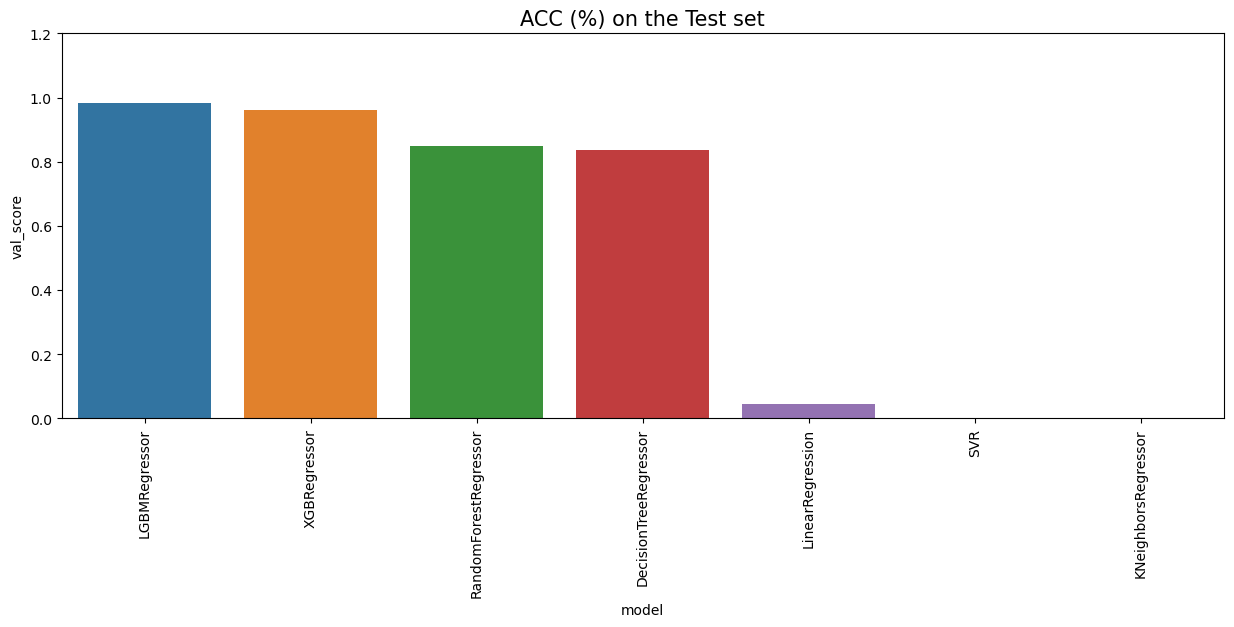

In [78]:
def check_performance_for_model(df_results):
    plt.figure(figsize = (15,5))
    sns.barplot(x = 'model', y = 'val_score', data = df_results)
    plt.title('ACC (%) on the Test set', fontsize = 15)
    plt.ylim(0,1.2)
    plt.xticks(rotation=90)
    plt.show()
    
check_performance_for_model(df_results)

### 예측

In [79]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

model = LGBMRegressor(verbose=-1)

model.fit(X_train_s, y_train_s)

y_test_pred = model.predict(X_test_s)
test_score = round(model.score(X_test_s, y_test_s),4)

dt_mae = mean_absolute_error(y_test, y_test_pred)

In [80]:
print(y_test_pred[:5])
print(list(y_test_s)[:5])

[ 7489.82336979  9874.02386071 -2316.01966383  2989.1228728
  3262.00458691]
[8809.0, 4210.0, 8488.0, 629.0, 2736.0]


In [81]:
print('acc:', test_score)
print('MAE:', dt_mae)

acc: 0.963
MAE: 48606.90276011867


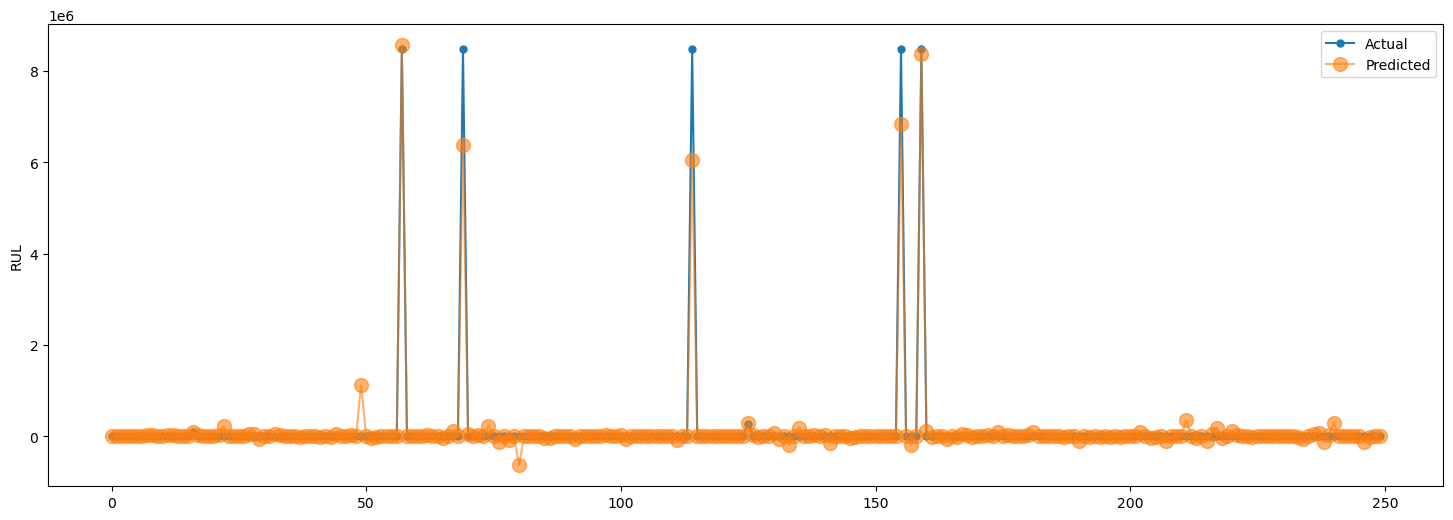

In [82]:
def eval_graph(y_valid, y_pred, cnt):
    plt.figure(figsize=(18,6))
    plt.plot(y_valid.values[:cnt], label='Actual',  marker = 'o', markersize=5)
    plt.plot(y_pred[:cnt], label='Predicted', alpha = 0.6,  marker = 'o', markersize=10)
    plt.legend()
    plt.ylabel('RUL')
    plt.show()

eval_graph(y_test_s, y_test_pred, 250)

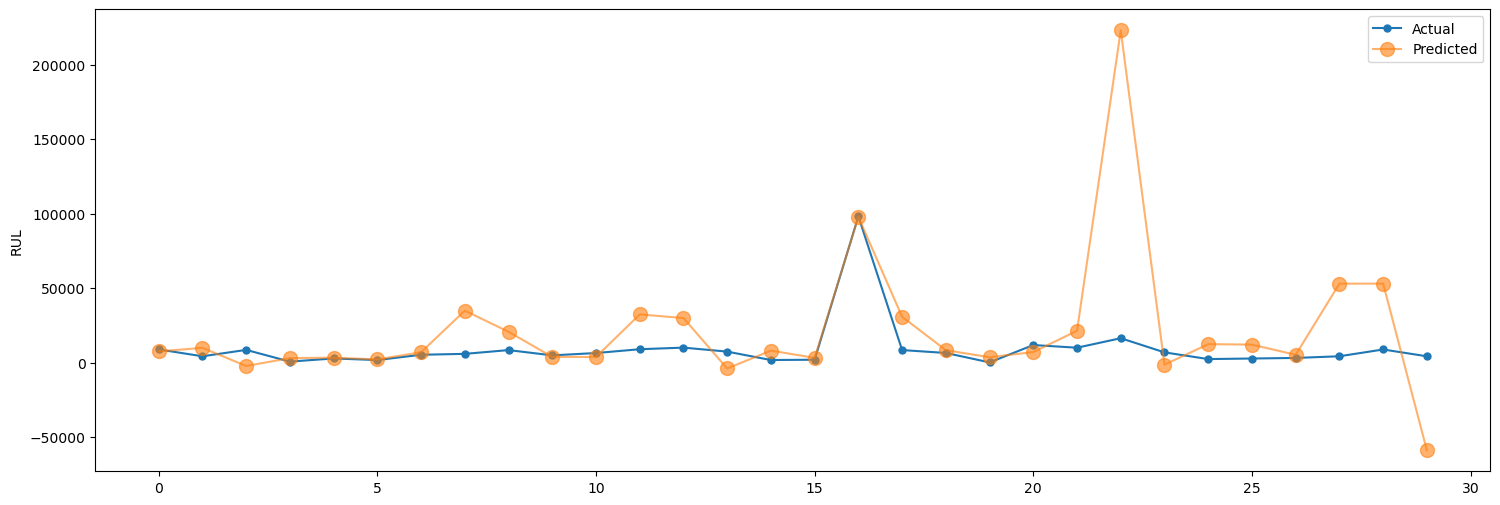

In [83]:
eval_graph(y_test_s, y_test_pred, 30)

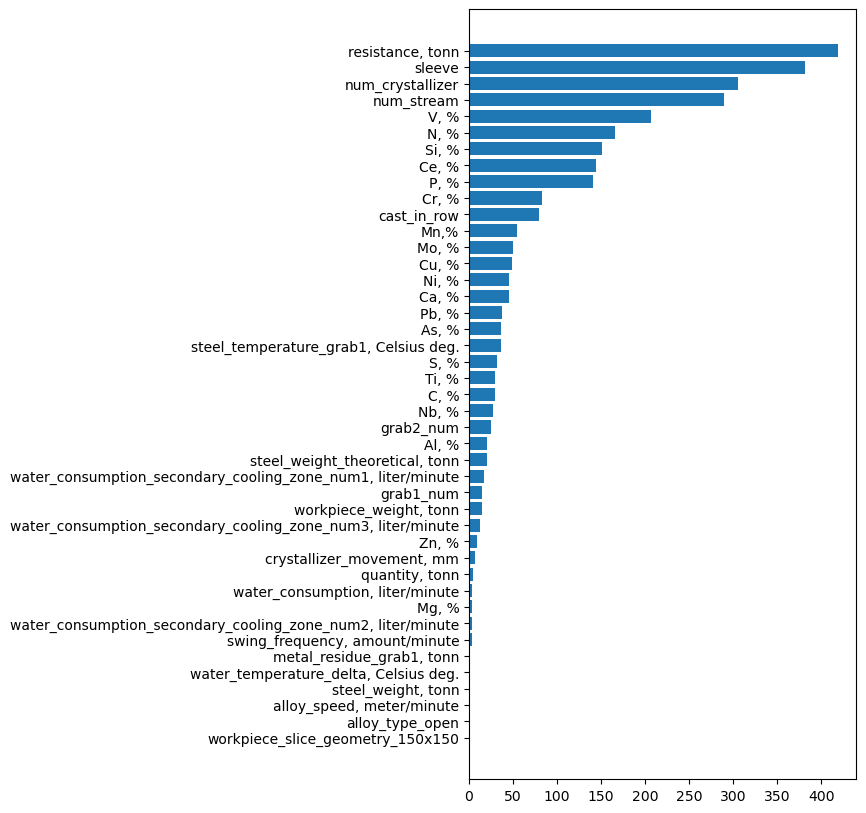

In [84]:
# 데이터프레임 만들기
perf_dic = {'feature':list(X),
            'importance': model.feature_importances_}
df = pd.DataFrame(perf_dic)
df.sort_values(by='importance', ascending=True, inplace=True)

# 시각화
plt.figure(figsize=(5, 10))
plt.barh(df['feature'], df['importance'])
plt.show()

RUL이 높은 경우 데이터셋이 굉장히 부족하기 때문에 eval_graph()에서 보여주는 그래프와 같은 결과가 나온다.

### 낮은 RUL과 높은 RUL 데이터셋을 나눠서 진행해본다.

In [89]:
high_RUL = df_Arm500[df_Arm500['RUL']>10000]
nomal_RUL = df_Arm500[df_Arm500['RUL']<10000]

print(len(high_RUL))
print(len(nomal_RUL))
print(high_RUL['RUL'].mean())
print(nomal_RUL['RUL'].mean())

1210
6706
937424.0363636364
4608.048464062034


In [90]:
X = nomal_RUL.drop(['RUL'], axis=1)
y = nomal_RUL['RUL']

In [91]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=2023, shuffle =True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2, random_state=2023, shuffle =True)

In [92]:
scaler = RobustScaler()
pipeline = Pipeline(scaler)

In [93]:
X_train_s, y_train_s = pipeline.fit(X_train, y_train)
X_val_s, y_val_s = pipeline.transform(X_val, y_val)

X_test_s, y_test_s = pipeline.transform(X_test, y_test)

In [94]:
from time import perf_counter

models = {
    "LinearRegression": {"model":LinearRegression()},
    "KNeighborsRegressor": {"model":KNeighborsRegressor(n_neighbors=3)},
    "DecisionTreeRegressor": {"model":DecisionTreeRegressor()},
    "RandomForestRegressor": {"model":RandomForestRegressor()},
    # "SVR": {"model":SVR(kernel='linear', C=1.0)},
    "XGBRegressor": {"model":XGBRegressor()},
    "LGBMRegressor": {"model":LGBMRegressor(verbose=-1)}
}

# Train모델 학습
for name, model in models.items():
    model = model['model']
    start = perf_counter()
    
    history = model.fit(X_train_s, y_train_s)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    
    y_train_pred = model.predict(X_train_s)
    y_val_pred = model.predict(X_val_s)
    
    train_score = round(model.score(X_train_s, y_train_s),4)
    val_score = round(model.score(X_val_s, y_val_s),4)
    
    models[name]['train_score'] = train_score
    models[name]['val_score'] = val_score
    
    print(f"{name:20} trained in {duration} sec, train_score: {train_score}. val_score: {val_score}")
    
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_score'], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_score','Training time (sec)'])
df_results.sort_values(by='val_score', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

LinearRegression     trained in 0.0 sec, train_score: 0.3182. val_score: 0.4167
KNeighborsRegressor  trained in 0.0 sec, train_score: 0.6204. val_score: 0.2644
DecisionTreeRegressor trained in 0.22 sec, train_score: 1.0. val_score: 0.9853
RandomForestRegressor trained in 13.45 sec, train_score: 0.9983. val_score: 0.9932
XGBRegressor         trained in 0.14 sec, train_score: 0.9994. val_score: 0.9929
LGBMRegressor        trained in 0.1 sec, train_score: 0.9955. val_score: 0.993


,model,val_score,Training time (sec)
0,RandomForestRegressor,0.9932,13.45
1,LGBMRegressor,0.9930,0.10
2,XGBRegressor,0.9929,0.14
3,DecisionTreeRegressor,0.9853,0.22
4,LinearRegression,0.4167,0.00
5,KNeighborsRegressor,0.2644,0.00


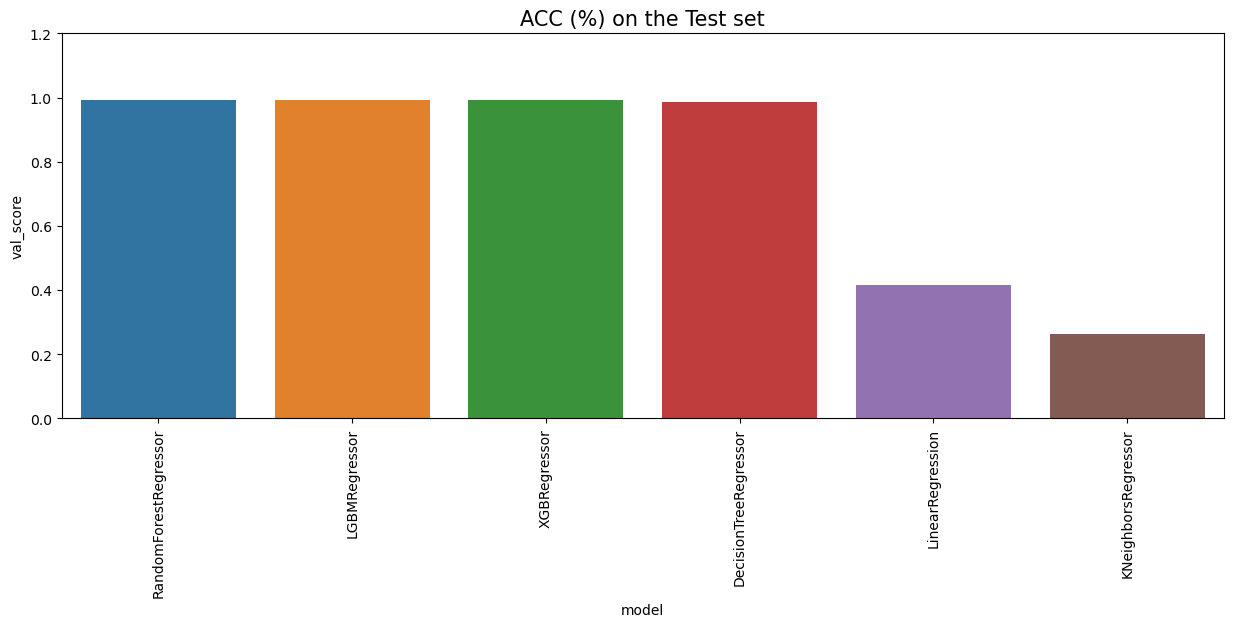

In [95]:
def check_performance_for_model(df_results):
    plt.figure(figsize = (15,5))
    sns.barplot(x = 'model', y = 'val_score', data = df_results)
    plt.title('ACC (%) on the Test set', fontsize = 15)
    plt.ylim(0,1.2)
    plt.xticks(rotation=90)
    plt.show()
    
check_performance_for_model(df_results)

In [96]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

model = LGBMRegressor(verbose=-1)

model.fit(X_train_s, y_train_s)

y_test_pred = model.predict(X_test_s)
test_score = round(model.score(X_test_s, y_test_s),4)

dt_mae = mean_absolute_error(y_test, y_test_pred)

In [97]:
print('acc:', test_score)
print('MAE:', dt_mae)

acc: 0.9878
MAE: 176.108754039883


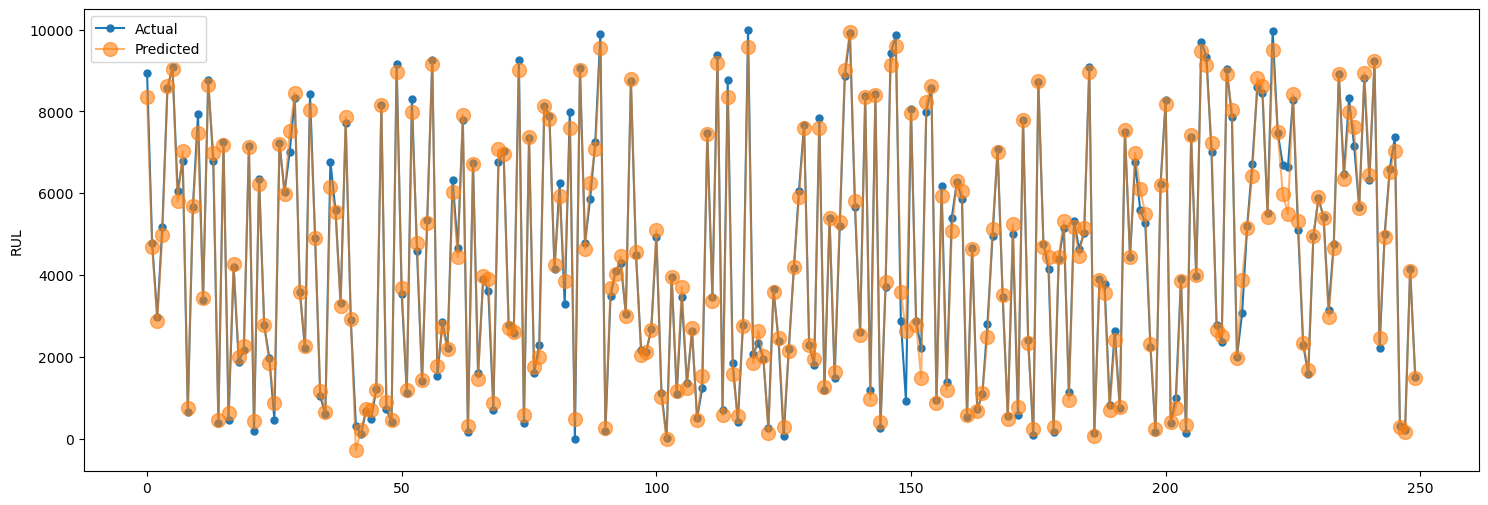

In [98]:
eval_graph(y_test_s, y_test_pred, 250)

RUL에 영향을 미치는 요인을 찾아보자

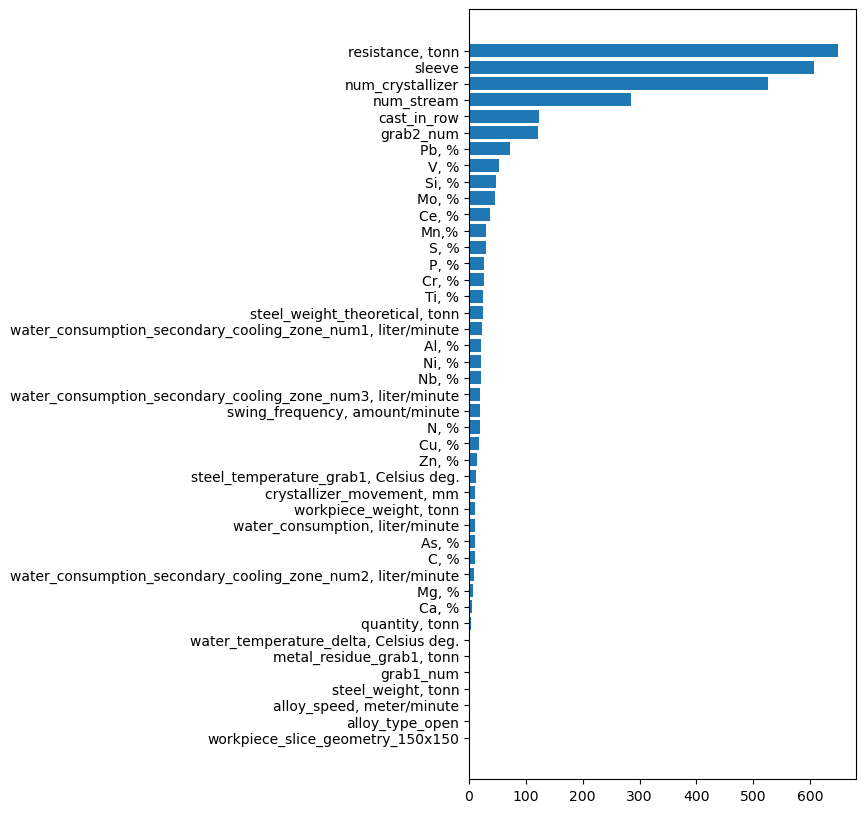

In [99]:
# 데이터프레임 만들기
perf_dic = {'feature':list(X),
            'importance': model.feature_importances_}
df = pd.DataFrame(perf_dic)
df.sort_values(by='importance', ascending=True, inplace=True)

# 시각화
plt.figure(figsize=(5, 10))
plt.barh(df['feature'], df['importance'])
plt.show()

### 높은 RUL을 갖는 데이터셋

In [109]:
print(len(high_RUL))

1210


In [110]:
X = high_RUL.drop(['RUL'], axis=1)
y = high_RUL['RUL']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=2023, shuffle =True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2, random_state=2023, shuffle =True)

In [111]:
X_train.shape, X_val.shape, X_test.shape

((847, 43), (290, 43), (73, 43))

In [112]:
scaler = RobustScaler()
pipeline = Pipeline(scaler)

X_train_s, y_train_s = pipeline.fit(X_train, y_train)
X_val_s, y_val_s = pipeline.transform(X_val, y_val)

X_test_s, y_test_s = pipeline.transform(X_test, y_test)

In [113]:
from time import perf_counter

models = {
    "LinearRegression": {"model":LinearRegression()},
    "KNeighborsRegressor": {"model":KNeighborsRegressor(n_neighbors=3)},
    "DecisionTreeRegressor": {"model":DecisionTreeRegressor()},
    "RandomForestRegressor": {"model":RandomForestRegressor()},
    # "SVR": {"model":SVR(kernel='linear', C=1.0)},
    "XGBRegressor": {"model":XGBRegressor()},
    "LGBMRegressor": {"model":LGBMRegressor(verbose=-1)}
}

# Train모델 학습
for name, model in models.items():
    model = model['model']
    start = perf_counter()
    
    history = model.fit(X_train_s, y_train_s)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    
    y_train_pred = model.predict(X_train_s)
    y_val_pred = model.predict(X_val_s)
    
    train_score = round(model.score(X_train_s, y_train_s),4)
    val_score = round(model.score(X_val_s, y_val_s),4)
    
    models[name]['train_score'] = train_score
    models[name]['val_score'] = val_score
    
    print(f"{name:20} trained in {duration} sec, train_score: {train_score}. val_score: {val_score}")
    
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_score'], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_score','Training time (sec)'])
df_results.sort_values(by='val_score', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

LinearRegression     trained in 0.0 sec, train_score: 0.4131. val_score: 0.3452
KNeighborsRegressor  trained in 0.0 sec, train_score: 0.6822. val_score: 0.4439
DecisionTreeRegressor trained in 0.05 sec, train_score: 1.0. val_score: 0.7346
RandomForestRegressor trained in 2.93 sec, train_score: 0.9796. val_score: 0.8643
XGBRegressor         trained in 0.11 sec, train_score: 1.0. val_score: 0.9786
LGBMRegressor        trained in 0.06 sec, train_score: 0.994. val_score: 0.9831


,model,val_score,Training time (sec)
0,LGBMRegressor,0.9831,0.06
1,XGBRegressor,0.9786,0.11
2,RandomForestRegressor,0.8643,2.93
3,DecisionTreeRegressor,0.7346,0.05
4,KNeighborsRegressor,0.4439,0.00
5,LinearRegression,0.3452,0.00


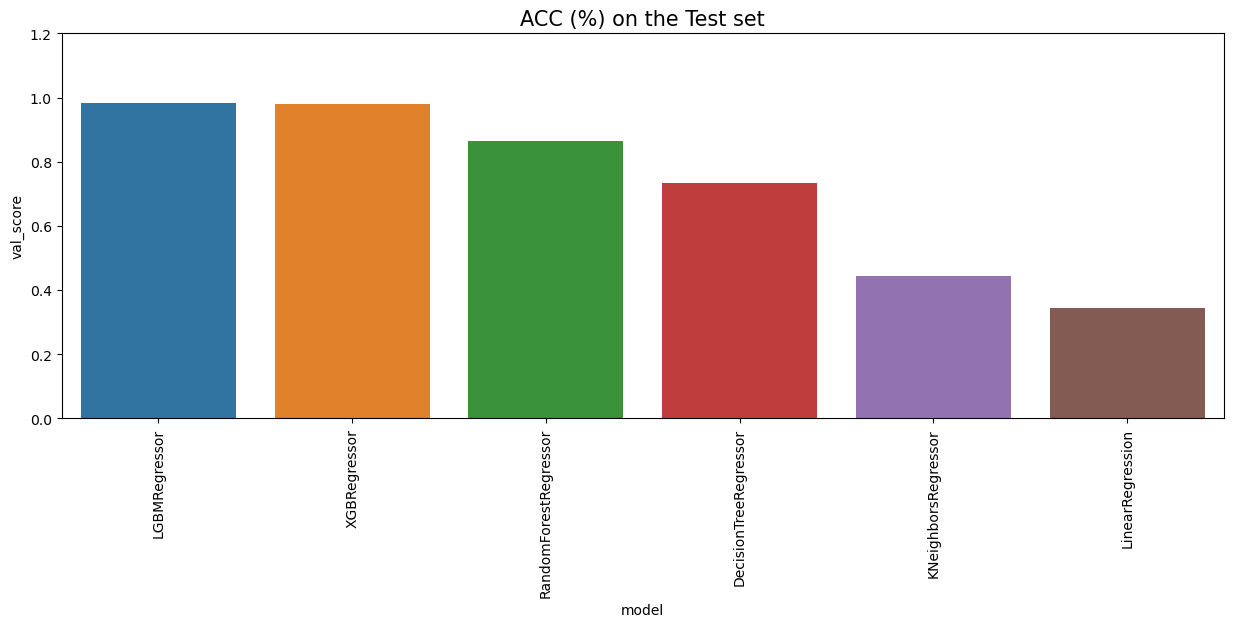

In [114]:
check_performance_for_model(df_results)

In [116]:

from sklearn.metrics import mean_absolute_error

model = LGBMRegressor(verbose=-1)

model.fit(X_train_s, y_train_s)

y_test_pred = model.predict(X_test_s)
test_score = round(model.score(X_test_s, y_test_s),4)

dt_mae = mean_absolute_error(y_test, y_test_pred)

In [117]:
print('acc:', test_score)
print('MAE:', dt_mae)

acc: 0.9783
MAE: 126728.43442353667


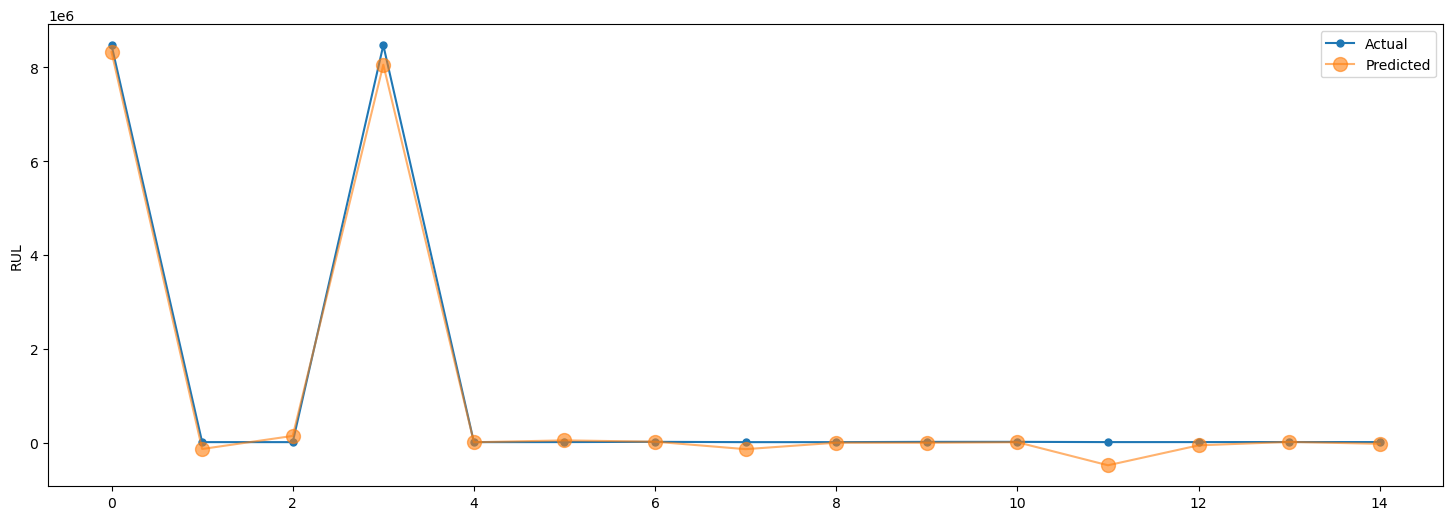

In [118]:
eval_graph(y_test_s, y_test_pred, 15)

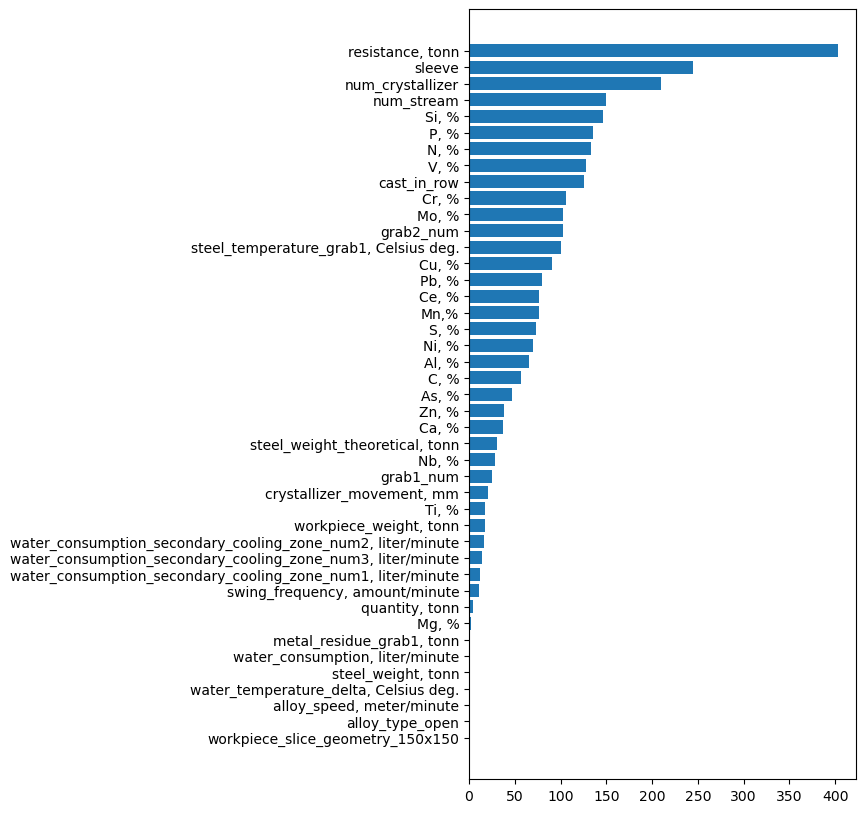

In [119]:
# 데이터프레임 만들기
perf_dic = {'feature':list(X),
            'importance': model.feature_importances_}
df = pd.DataFrame(perf_dic)
df.sort_values(by='importance', ascending=True, inplace=True)

# 시각화
plt.figure(figsize=(5, 10))
plt.barh(df['feature'], df['importance'])
plt.show()

### 분석결과

결과적으로 RUL 설명과 공식에서 알수 있듯이 RUL은 "resistance, tonn", "sleeve", "num_crystallizer", "num_stream"에 가장 관련이 있음을 알수 있다.

이외에도 다양한 원소 비율들로 RUL이 정해질 수 있음을 알수 있다. 